<br><br>
<font size='6'><b>Recurrent Neural Networks (RNN)
</b></font><br><br>

<table style="border-style: hidden; border-collapse: collapse;" width = "80%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 60% style="border-style: hidden; border-collapse: collapse;">

        </td>
        <td width = 20%>
        By Prof. Seungchul Lee<br>iSystems Design Lab<br>http://isystems.unist.ac.kr/<br>UNIST
        </td>
    </tr>
</table>

Table of Contents
<div id="toc"></div>

# 1. Recurrent Neural Networks (RNN)

- RNNs are a family of neural networks for processing __sequential data__

- Traditional methods for sequential data
    - Time series analysis, Kalman filter, Hidden Markov model

## 1.1. Feedforward Network and Sequential Data

<br>
<img src="./image_files/sequence_layer.jpg" width = 400>
<br>

- Separated parameters for each value of the time index
    - Cannot share statistical strength across different time indices

## 1.2. Structure of RNN

__ Recurrence __
- It is possible to use the __same__ transition function $f$ with the same parameters at every time step

<br>
<img src="./image_files/sequence_layer_dependv2.jpg" width = 370>
<br>

__ Hidden State __
- Lossy summary of the the past sequence of inputs up to $t$
- Keep some aspects of the past sequence with more precision than other aspects
- Network learns the function $f$
$$  h^{(t)} = f\left(h^{(t-1)}, x^{(t)}\right) $$
$$ f\left(h^{(t-1)}, x^{(t)}\right) = g\left(Wx_{t} + Uh_{t-1}\right) $$



<table style="border-style: hidden; border-collapse: collapse;" width = "96%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 48% style="border-style: hidden; border-collapse: collapse;">
<img src="./image_files/micro_view_rnn.jpg" width = 400>
        </td>
        <td width = 48%>
<img src="./image_files/recurrence_gif.gif" width = 400>
        </td>
    </tr>
</table>
<br>

__ Deep Recurrent Networks __
- Three blocks of parameters and associated transformation
    1. From the input to the hidden state (from green to yellow)
    2. From the previous hidden state to the next hidden state (from yellow to red)
    3. From the hidden state to the output (from red to blue)
    
<br>
<img src="./image_files/deep_RNN.PNG" width = 300>
<br>

## 1.3. LSTM RNN

__ Long-Term Dependencies __
- Gradients propagated over many stages tend to either vanish or explode
- Difficulty with long-term dependencies arises from the exponentially smaller weights given to long-term interactions

<br>
<img src="./image_files/vanishing_gradient.jpg" width = 550>
<br>

__ Long Short-Term Memory (LSTM) __
- Allow the network to __accumulate__ information over a long duration
- Once that information has been used, it might be use for the neural network to __forget__ the old state

<br>
<img src="./image_files/gates_lstm.png" width = 550>


## 1.4. Classification and Prediction

<table style="border-style: hidden; border-collapse: collapse;" width = "96%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 48% style="border-style: hidden; border-collapse: collapse;">
            <img src="./image_files/RNN_Structure.png" width = 450>
        </td>
        <td width = 48% style="border-style: hidden; border-collapse: collapse;">
            <img src="./image_files/RNN_forecast.png" width = 350>
        </td>
    </tr>
</table>


# 2. RNN with TensorFlow

- Will predict a future time signal

## 2.1. Import Library

In [6]:
from six.moves import cPickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 2.2. Load Time Series Data
- Import an accelerometer signal of rotating machinery

(82000,)


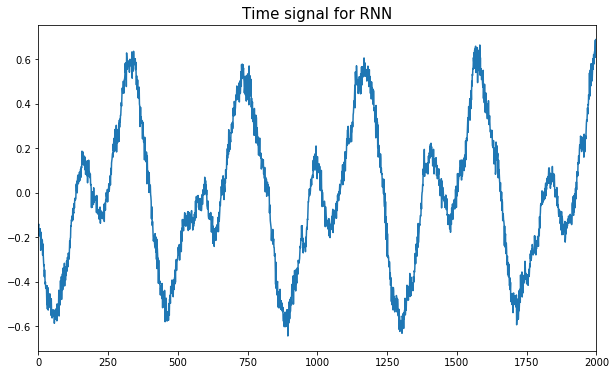

In [8]:
data =  cPickle.load(open('./data_files/rnn_time_signal.pkl', 'rb'))

print(data.shape)
plt.figure(figsize=(10,6))
plt.title('Time signal for RNN', fontsize=15)
plt.plot(data[0:2000])
plt.xlim(0,2000)
plt.show()

## 2.3. Define a RNN Shape

<br>
<img src="./image_files/RNN_ac.png" width = 650>
<br>

In [9]:
## 2500 + 100 = 2600
n_step = 25
n_input = 100
n_output = 100

## LSTM shape
n_hidden1 = 100
n_hidden2 = 100

## Fully connected
n_hidden3 = 100

## 2.4. Define Weights and Biases

__LSTM Cell__
- Do not need to define weights of LSTM cell

__ Fully connected__
- Define parameters based on predefined layer size
- Initialize with normal distribution with $\mu = 0$ and $\sigma = 0.01$


In [10]:
weights = {
    'w1' : tf.Variable(tf.random_normal([n_hidden2, n_hidden3], stddev=0.01)),
    'w2' : tf.Variable(tf.random_normal([n_hidden3, n_output], stddev=0.01))
}
biases = {
    'b1' : tf.Variable(tf.random_normal([n_hidden3], stddev=0.01)),
    'b2' : tf.Variable(tf.random_normal([n_output], stddev=0.01))
}

## 2.5. Build a Model

__ Build a RNN Network __
- First, define LSTM cell
```python
lstm = tf.contrib.rnn.BasicLSTMCell(n_hidden)
```
- Second, compute hidden state (h) and LSTM cell (c) with predefined LSTM cell and input
```python
h, c = tf.nn.dynamic_rnn(lstm, input_tensor, dtype=tf.float32)
```

In [11]:
def net(x, weights, biases):
    with tf.variable_scope('rnn'):
        # Build RNN network
        with tf.variable_scope('lstm1'):
            #rnn_cell1 = tf.contrib.rnn.BasicRNNCell(n_hidden1)
            lstm1 = tf.contrib.rnn.BasicLSTMCell(n_hidden1)
            h1, c1 = tf.nn.dynamic_rnn(lstm1, x, dtype=tf.float32)
        with tf.variable_scope('lstm2'):
            #rnn_cell2 = tf.contrib.rnn.BasicRNNCell(n_hidden2)
            lstm2 = tf.contrib.rnn.BasicLSTMCell(n_hidden2)
            h2, c2 = tf.nn.dynamic_rnn(lstm2, h1, dtype=tf.float32)
            
        # Build classifier
        hidden = tf.matmul(h2[:, -1, :], weights['w1']) + biases['b1']
        hidden = tf.nn.relu(hidden)
        pred = tf.matmul(hidden, weights['w2']) + biases['b2']
        return pred

## 2.6. Define Loss, Initializer and Optimizer
__Loss__

- Regression: squared loss
$$  \frac{1}{N}\sum_{i=1}^{N}  \left(h_{\theta}\left(x^{(i)}\right) - y^{(i)}\right)^2$$

__Initializer__
- Initialize all the empty variables
    
__Optimizer__
- AdamOptimizer: the most popular optimizer

In [12]:
learning_rate = 0.0001
x = tf.placeholder(tf.float32, [None, n_step, n_input])
y = tf.placeholder(tf.float32, [None, n_output])

pred = net(x, weights, biases)
cost = tf.reduce_mean(tf.square(y - pred))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

## 2.7. Summary of Model

<br>
<img src="./image_files/cnn_summary of model.png" width = 500>
<br>

## 2.7. Define Configuration

- Define parameters for training RNN
     - The number of iteration: number of training steps
     - Flag: check cost for every flag iteration

In [13]:
n_iter = 5000
flag = 250
stride = 5

## 2.8. Optimization

Do not run during the tutorial.

In [14]:
sess = tf.Session()
sess.run(init)

for i in range(n_iter):
    batch_x = data[i*stride : i*stride + n_step*n_input]
    batch_x = batch_x.reshape(n_step, n_input)
    batch_x = batch_x[np.newaxis, :]
    
    batch_y = data[i*stride + n_step*n_input : i*stride + n_step*n_input + n_output]
    batch_y = batch_y[np.newaxis, :]
    
    sess.run(optimizer, feed_dict={x: batch_x,  y: batch_y})
    
    if i % flag == 0:
        c = sess.run(cost, feed_dict={x: batch_x,  y: batch_y})
        print ("Iter : {}".format(i))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 0.18625779449939728
Iter : 250
Cost : 0.1934627890586853
Iter : 500
Cost : 0.24208885431289673
Iter : 750
Cost : 0.18274544179439545
Iter : 1000
Cost : 0.24883265793323517
Iter : 1250
Cost : 0.2003261148929596
Iter : 1500
Cost : 0.07145676761865616
Iter : 1750
Cost : 0.01791026070713997
Iter : 2000
Cost : 0.011809381656348705
Iter : 2250
Cost : 0.01172390952706337
Iter : 2500
Cost : 0.004237829241901636
Iter : 2750
Cost : 0.001899329712614417
Iter : 3000
Cost : 0.006315190345048904
Iter : 3250
Cost : 0.028805598616600037
Iter : 3500
Cost : 0.015894679352641106
Iter : 3750
Cost : 0.010971460491418839
Iter : 4000
Cost : 0.012138872407376766
Iter : 4250
Cost : 0.004057416692376137
Iter : 4500
Cost : 0.014416809193789959
Iter : 4750
Cost : 0.015981972217559814


## 2.9. Test
- Generate the future time signal

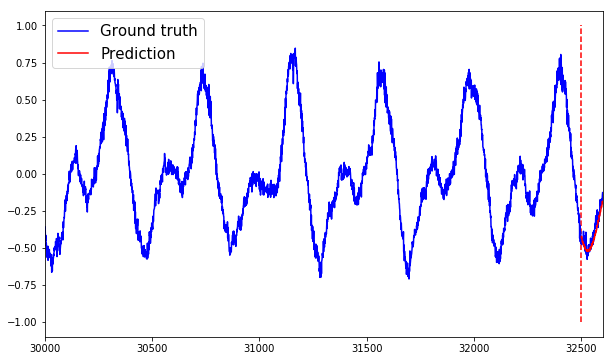

In [33]:
start = 30000

test_x = data[start : start + n_step*n_input]
test_x = test_x.reshape(n_step, n_input)
test_x = test_x[np.newaxis, :]

ground_truth = data[start : start + n_step*n_input + n_output]

test_pred = sess.run(pred, feed_dict={x : test_x})

plt.figure(figsize=(10,6))
plt.plot(np.arange(start, start + n_step*n_input + n_output), ground_truth, 'b', label='Ground truth')
plt.plot(np.arange(start + n_step*n_input, start + n_step*n_input + n_output), test_pred.ravel(), \
         'r', label='Prediction')
plt.vlines(start + n_step*n_input, -1, 1, colors = 'r', linestyles='dashed')
plt.legend(fontsize=15, loc='upper left')
plt.xlim(start, start + n_step*n_input + n_output)
plt.show()


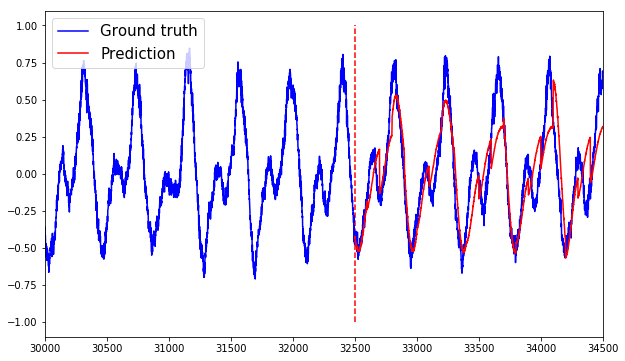

In [34]:
start = 30000

test_x = data[start : start + n_step*n_input]
test_x = test_x.reshape(n_step, n_input)
test_x = test_x[np.newaxis, :]

ground_truth = data[start : start + n_step*n_input + 20*n_input]

gen_signal = []

for i in range(20):
    test_pred = sess.run(pred, feed_dict={x : test_x})
    gen_signal.append(test_pred.ravel())
    test_pred = test_pred[:, np.newaxis, :]
    
    test_x = test_x[:, 1:, :]
    test_x = np.concatenate([test_x, test_pred], axis=1)
    
gen_signal = np.concatenate(gen_signal)

plt.figure(figsize=(10,6))
plt.plot(np.arange(start, start + n_step*n_input + 20*n_input), ground_truth, 'b', label='Ground truth')
plt.plot(np.arange(start + n_step*n_input,  start + n_step*n_input + 20*n_input), gen_signal, 'r', label='Prediction')
plt.vlines(start + n_step*n_input, -1, 1, colors = 'r', linestyles='dashed')
plt.legend(fontsize=15, loc='upper left')
plt.xlim(start, start + n_step*n_input + 20*n_input)
plt.show()

# 3. Deep Learning of Things

- RNN implimented in an Embedded System
- But this RNN demo is not a predictor, but a classifier

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>